In [1]:
%load_ext autoreload
%autoreload 2

### imports and utilities

In [2]:
!pip install nltk scikit-learn matplotlib scipy

You should consider upgrading via the 'C:\Users\christian\Documents\christian\work\python\cyberspace\topic_modeler\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [3]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\christian\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\christian\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\christian\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [12]:
from collections import Counter
from utils import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.special import softmax
from scipy.stats import norm
from scipy.stats import entropy as calculate_entropy

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### load dataset

In [5]:
dataset = "newsgroup"

# total number of samples needed
randomize = False

# retrieve dataset
categories = ['rec.autos', 'talk.politics.mideast', 'alt.atheism', 'sci.space']

all_docs = fetch_20newsgroups(subset='train', shuffle=randomize, remove=('headers', 'footers', 'quotes'), categories=categories)
all_docs, old_labels, classes = all_docs.data, all_docs.target, all_docs.target_names

In [6]:
# dataset = "bbc"

# data = pd.read_csv('bbcsport.csv')

# all_docs = data["text"].to_list()
# old_labels = data["topic"].to_list()
# categories = classes = np.unique(data["topic"]).tolist()

### clean dataset

In [8]:
datasize = 50
min_document_length = 256
max_document_length = 512


index = -1
docs, labels, label_indices = [], [], []

sizes = [0]*len(categories)

with tqdm(total=len(categories)*datasize) as pbar:
    while sum(sizes) != len(categories)*datasize:
        index += 1
        
        if dataset == "bbc":
            size_index = categories.index(old_labels[index])
            
        else:
            size_index = categories.index(classes[old_labels[index]])
        
        if sizes[size_index] == datasize:
            continue
        
        doc = all_docs[index]
        status, doc, word_count = clean_doc(doc, True)
        
        if not status:
            continue
            
        if min_document_length is not None and len(doc) < min_document_length:
            continue
            
        if max_document_length is not None and len(doc) > max_document_length:
            continue
        
        label_indices.append(size_index)
        labels.append(categories[size_index])
        docs.append(doc)
        sizes[size_index] += 1
        pbar.update(1)

labels = np.array(labels)
label_indices = np.array(label_indices)

In [9]:
index = 3
print(f"Topic: {labels[index]}\n{'='*50}\n{docs[index][:512]}")

Topic: sci.space
sorry folk i should have do this and meant to just after i hit the send key orbital element of comet 1977vii from dance file p au 3 424346 e 0 151899 i 1 0988 cap omega 0 243 5652 w 0 231 1607 epoch 1977 04110 also perihelion of gehrels3 be april 1973 83 jupiter radius august 1970 3 jupiter radius hope this help i m even le of an orbital mechanic than i be an artist


In [10]:
print(sizes)
assert min(sizes) == max(sizes) == datasize

[50, 50, 50, 50]


## Split data

In [45]:
x_train, x_test, y_train, y_test = train_test_split(docs, labels, test_size =.3)

In [46]:
print(f"there are {len(docs)} total docs, {len(y_train)} train and {len(y_test)} test")

there are 200 total docs, 140 train and 60 test


### Initialize Vectorizer

In [47]:
# initialize the count vectorizer
vectorizer = CountVectorizer()

# fit it to dataset
vectorizer.fit(x_train)

vocabulary = np.array(vectorizer.get_feature_names())
print("word_count is", len(vocabulary))

word_count is 2510


### Prepare Datatset

In [48]:
# create doc count vectors
train_doc_vectors = vectorizer.transform(x_train).toarray()
test_doc_vectors = vectorizer.transform(x_test).toarray()

In [52]:
# reduce freq in doc to bin value of 1 or 0
word_freq_in_doc_train = pd.DataFrame(train_doc_vectors, columns=vocabulary)
word_freq_in_doc_test = pd.DataFrame(test_doc_vectors, columns=vocabulary)

word_doc_frequency_norm_train = (word_freq_in_doc_train.T / word_freq_in_doc_train.sum(1)).T
word_doc_frequency_norm_test = (word_freq_in_doc_test.T / word_freq_in_doc_test.sum(1)).T

wdf_train = word_doc_frequency_norm_train.copy()
wdf_test = word_doc_frequency_norm_test.copy()

# wdf_train = (word_doc_frequency_norm_train > 0).astype(int)
# wdf_test = (word_doc_frequency_norm_test > 0).astype(int)

## Word Topic Probability Distr

In [53]:
wdt_train = wdf_train.copy()
wdt_test = wdf_test.copy()

wdt_test["__labels__"] = y_test
wdt_train["__labels__"] = y_train

topic_count = pd.DataFrame(Counter(y_train), index=[0]).T[0]
word_topic_pr_distr = pd.DataFrame(data=0.0, columns=categories, index=vocabulary)

for category in tqdm(categories):
    pxy = wdf_train[wdt_train["__labels__"] == category].sum(0) / topic_count[category]
    word_topic_pr_distr[category] = pxy * (topic_count[category] / wdf_train.sum(0))

print(f"word_topic_pr_distr shape = {word_topic_pr_distr.shape}")


word_topic_pr_distr shape = (2510, 4)


In [54]:
word_topic_pr_distr.head()

,rec.autos,talk.politics.mideast,alt.atheism,sci.space
000,0.0,1.0,0.0,0.0
02,1.0,0.0,0.0,0.0
034101,0.0,0.0,0.0,1.0
04110,0.0,0.0,0.0,1.0
0710,1.0,0.0,0.0,0.0


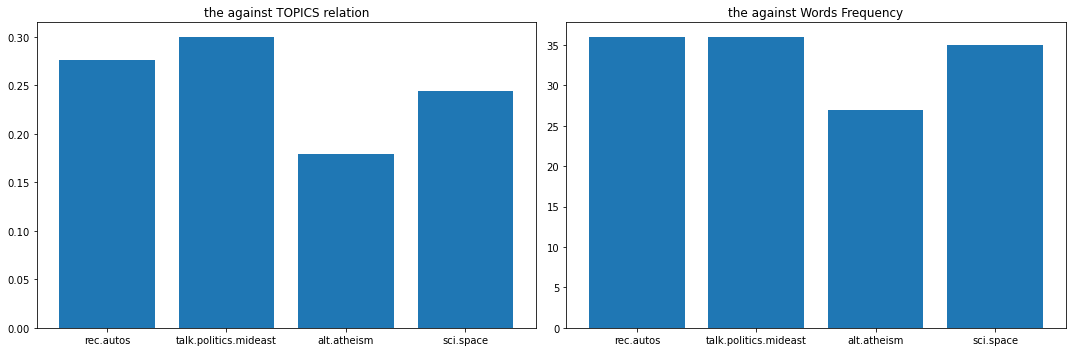

In [55]:
word = "the"

fig = plt.figure(figsize=(15, 5), tight_layout=True)
ax11 = fig.add_subplot(121)
ax12 = fig.add_subplot(122)

ax11.set_title(f"{word} against TOPICS relation")
ax11.bar(word_topic_pr_distr.columns, word_topic_pr_distr.loc[word])

word_topic_freq = Counter(wdt_train["__labels__"][wdt_train[word] > 0])
freqs = []
for topic in word_topic_pr_distr.columns:
    freqs.append(word_topic_freq[topic])
#     freqs.append(word_topic_freq[topic] / topic_count[topic])

ax12.set_title(f"{word} against Words Frequency")
ax12.bar(word_topic_pr_distr.columns, freqs)

plt.show()

### Quick Topic Inference

In [56]:
doc_index = 0
doc_vector = wdf_train.loc[doc_index]
_, predicted_doc_topic = infer_topic(categories, doc_vector, word_topic_pr_distr)
print(f"actual = {wdt_train.loc[doc_index]['__labels__']}, predicted = {predicted_doc_topic}")

actual = rec.autos, predicted = rec.autos


## Topic Word Distr - Train Accuracy

In [57]:
score_train = 0
for doc_index in tqdm(range(len(y_train))):
    doc_vector = wdf_train.loc[doc_index]
    _, predicted_doc_topic = infer_topic(categories, doc_vector, word_topic_pr_distr)
    
    mark = wdt_train.loc[doc_index]['__labels__'] == predicted_doc_topic
    score_train += mark

train_accuracy = score_train / len(y_train)
print(f"accuracy = {train_accuracy: .4f}")


accuracy =  0.9214


## Topic Word Distr - Test Accuracy

In [58]:
score_test = 0
for doc_index in tqdm(range(len(y_test))):
    doc_vector = wdf_test.loc[doc_index]
    _, predicted_doc_topic = infer_topic(categories, doc_vector, word_topic_pr_distr)
    
    mark = wdt_test.loc[doc_index]['__labels__'] == predicted_doc_topic
    score_test += mark

test_accuracy = score_test / len(y_test)
print(f"test accuracy = {test_accuracy: .4f}")


test accuracy =  0.4500


In [155]:
topic_index = 3
topic = categories[topic_index]

print(topic)
word_topic_pr_distr[topic].sort_values(ascending=False).head(10)

sci.space


orbit           1.0
remain          1.0
residue         1.0
researcher      1.0
engineer        1.0
reprogrammed    1.0
inner           1.0
input           1.0
inquire         1.0
insert          1.0
Name: sci.space, dtype: float64

In [131]:
topic_index = 3
topic = categories[topic_index]

print(topic)
word_topic_pr_distr[topic].sort_values(ascending=False).head(10)

sci.space


orbit           1.0
remain          1.0
residue         1.0
researcher      1.0
engineer        1.0
reprogrammed    1.0
inner           1.0
input           1.0
inquire         1.0
insert          1.0
Name: sci.space, dtype: float64

In [74]:
doc_topic = []

for topic in tqdm(categories):
    doc_topic.append(word_topic_pr_distr[topic] * word_doc_frequency_norm)

Documnet: 0, Topic: sci.space
kudos to mark for his generous offer but there already exists a large email base forward system for sci space post space digest it mirror sci space exactly and provide simple two way communication to subscribe send the follow message in the body not subject of an email message subscribe space john q public to one of these address listserv uga listserv uga cc uga edu listserv finhutc listserv finhuc hut fi space request isu isunet edu you ll receive all the post in digest form once a day please use a listser


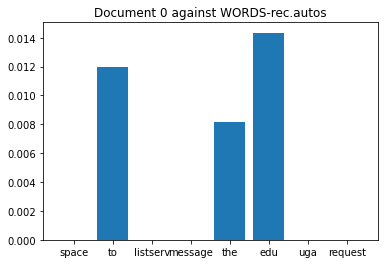

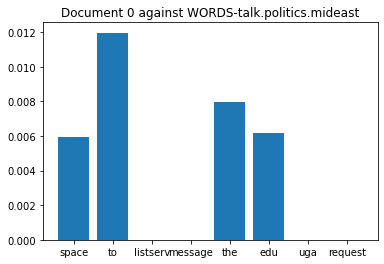

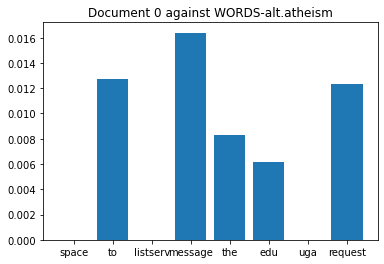

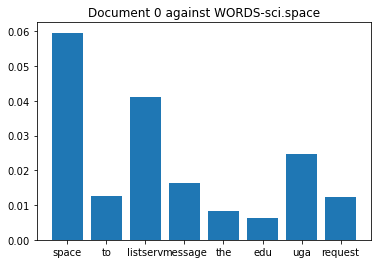

In [102]:
doc_index = 0
print(f"Documnet: {doc_index}, Topic: {labels[doc_index]}\n{'='*50}\n{train_docs[doc_index][:512]}")

words = word_doc_frequency_norm.loc[doc_index].sort_values(ascending=False).index[:8]

for topic_index in range(len(categories)):
    values = doc_topic[topic_index].loc[doc_index][words]
    plt.title(f"Document {doc_index} against WORDS-{categories[topic_index]}")
    plt.bar(words, values)
    
    plt.show()

### Word-Word Ratio

In [13]:
# reduce freq in doc to bin value of 1 or 0
word_freq_in_doc = pd.DataFrame(train_doc_vectors, columns=vocabulary)
word_doc_frequency_norm = (word_freq_in_doc.T / word_freq_in_doc.sum(1)).T

wdf = word_doc_frequency_norm.copy()
# wdf = (word_doc_frequency_norm > 0).astype(int)
doc_word_distr = wdf.copy()

word_word_co = pd.DataFrame(data=0.0, columns=vocabulary, index=vocabulary)
doc_word_distr = doc_word_distr.T
probability = doc_word_distr.mean(1)

for word in tqdm(vocabulary):
    wwcr = (doc_word_distr * doc_word_distr.loc[word]).sum(1) / doc_word_distr.loc[word].sum()
    word_word_co.loc[word] = wwcr * (probability[word] / probability)

print(f"word_word_co shape = {word_word_co.shape}")


word_word_co shape = (4476, 4476)


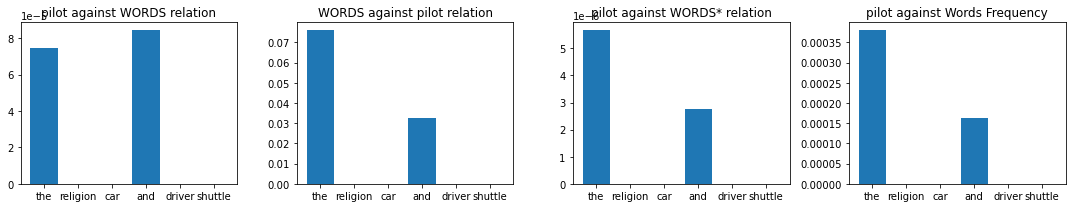

In [14]:
random_plot = False

word = "pilot"
words = ["the", "religion", "car", "and", "driver", "shuttle"]

if random_plot:
    words = np.array(vocabulary)[np.random.randint(len(vocabulary), size=5)]
    word = words[0]

fig = plt.figure(figsize=(15,3), tight_layout=True)
ax11 = fig.add_subplot(141)
ax12 = fig.add_subplot(142)
ax13 = fig.add_subplot(143)
ax14 = fig.add_subplot(144)

ax11.set_title(f"{word} against WORDS relation")
ax11.bar(words, word_word_co.loc[word][words])

ax12.set_title(f"WORDS against {word} relation")
ax12.bar(words, word_word_co[word][words])

ax13.set_title(f"{word} against WORDS* relation")
ax13.bar(words, (word_word_co * word_word_co.T).loc[word][words])

pxy = word_doc_frequency_norm[word_doc_frequency_norm[word] > 0].sum(0)
pxy /= total_num_of_documents

ax14.set_title(f"{word} against Words Frequency")
ax14.bar(words, pxy[words])

plt.show()

In [55]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

model = GaussianNB()

word = "space"
x_test = word_word_co.copy()
# x_test = doc_word_distr.T.copy()
y_test = (x_test[word] > 0).astype(int)
x_test = x_test.drop(columns=[word])

model.fit(x_test, y_test)
y_pred = model.predict(x_test)

print ("Scikit-learn GaussianNB accuracy: {0:.3f}".format(accuracy_score(y_test, y_pred)))

Scikit-learn GaussianNB accuracy: 0.983


In [60]:
vocabulary[model.theta_[1].argsort()[::-1]][:15]

array(['painting', 'comercial', 'pi', 'consistent', 'innovative', 'pepsi',
       'ozone', 'industrial', 'catch', 'cu', 'coke', 'movie',
       'probability', 'advert', 'proposal'], dtype='<U17')

In [59]:
print(word)
word_word_co.loc[word].sort_values(ascending=False).head(15)

space


listserv     0.065574
mirror       0.065574
finhuc       0.065574
finhutc      0.065574
hut          0.065574
manually     0.065574
kudos        0.065574
subscribe    0.065574
isu          0.065574
isunet       0.065574
uga          0.065574
request      0.051439
digest       0.051058
message      0.046343
fi           0.038082
Name: space, dtype: float64

In [ ]:
doc_word_distr = wdf.copy()

for doc_index in (range(total_num_of_documents)):
    words = doc_word_distr.columns[doc_word_distr.loc[doc_index] > 0]
    doc_word_distr.loc[doc_index] = (doc_word_distr.loc[doc_index][words] * word_word_co.loc[words].T).T.max(0)
    pbar.update(1)


In [27]:
doc_index = 19
word_doc_frequency_norm.iloc[doc_index].sort_values(ascending=False).head(10)

be              0.076923
and             0.048951
the             0.041958
about           0.034965
you             0.034965
to              0.034965
belief          0.027972
that            0.027972
in              0.027972
supernatural    0.020979
Name: 19, dtype: float64

In [38]:
doc_word_distr.iloc[doc_index].sort_values(ascending=False).head(20)

excitable       1.000000
earthly         1.000000
deity           1.000000
ibility         1.000000
worship         1.000000
tendency        1.000000
sceptical       1.000000
beside          1.000000
ideology        1.000000
autonomous      1.000000
gullible        1.000000
hero            1.000000
suscept         1.000000
supernatural    1.000000
indicates       0.615385
tyrant          0.602564
critical        0.596154
criterion       0.517094
behaviour       0.487179
divide          0.482906
Name: 19, dtype: float64

In [29]:
print(f"Topic: {labels[doc_index]}\n{'='*50}\n{train_docs[doc_index][:512]}")

Topic: alt.atheism
and that of course be the point you can t simply divide the world into atheist and non atheist on the basis of god belief if all you care about be belief in a supernatural deity and have nothing to say about behaviour then belief in a supernatural be be your criterion but once you start talk about behaviour then someone s suscept ibility to be lead by bad people into do bad thing be what you be i assume worried about and in that area what you care about be whether someone be sceptical critical and autonomou


In [44]:
doc_index = 18
word_doc_frequency_norm.iloc[doc_index].sort_values(ascending=False).head(10)

be           0.088235
that         0.058824
to           0.049020
it           0.049020
this         0.029412
take         0.029412
freedom      0.029412
objective    0.029412
their        0.029412
assert       0.019608
Name: 18, dtype: float64

In [45]:
doc_word_distr.iloc[doc_index].sort_values(ascending=False).head(20)

rain           1.000000
valuable       1.000000
utterly        1.000000
assert         1.000000
contrary       1.000000
wild           1.000000
candidate      1.000000
volition       1.000000
rainy          1.000000
objectively    1.000000
deprive        0.666667
complain       0.650000
absurd         0.625000
assumption     0.625000
freedom        0.522222
condition      0.505556
objective      0.488889
necessary      0.450000
therefore      0.437500
almost         0.400000
Name: 18, dtype: float64

In [46]:
print(f"Topic: {labels[doc_index]}\n{'='*50}\n{train_docs[doc_index][:512]}")

Topic: alt.atheism
i ll take a wild guess and say freedom be objectively valuable i base this on the assumption that if everyone in the world be deprive utterly of their freedom so that their every act be contrary to their volition almost all would want to complain therefore i take it that to assert or believe that freedom be not very valuable when almost everyone can see that it be be every bit a absurd a to assert it be not rain on a rainy day i take this to be a candidate for an objective value and it it be a necessary con


### Define Latent partitions

In [ ]:
reduction = None
# reduction = "pca"
# reduction = "normal"

if reduction is None:
    columns = doc_word_distr.columns
    param_values = doc_word_distr.values

if reduction == "pca":
    num_of_components = 2
    columns = list(range(num_of_components))
    
    pca = PCA(n_components=num_of_components, whiten=True)
    param_values = pca.fit_transform(doc_word_distr)

if reduction == "normal":
    columns = ["mean", "std"]
    column_values = [doc_word_distr.sum(1), doc_word_distr.mean(1)]
    param_values = np.array(column_values).T
    
distr_params = pd.DataFrame(data=param_values, columns=columns, index=list(range(len(doc_word_distr))))
print(f"distr_params has shape {distr_params.shape}")

In [ ]:
distr_params.head()

### Using Kmeans MiniBatch

In [ ]:
num_of_topics = 4

In [ ]:
kmeans_model = KMeans(n_clusters=num_of_topics, random_state=0).fit(distr_params)

In [ ]:
dist = kmeans_model.transform(distr_params)
predicted_labels = kmeans_model.predict(distr_params)
wtf = gaussian(normalize(dist, norm="l1", axis=1))

print(f"dist has shape {dist.shape}, predicted_labels has shape {predicted_labels.shape}")

In [ ]:
Counter(predicted_labels)

In [ ]:
fig = plt.figure(figsize=(15,5), tight_layout=True)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title("Documents Space")
ax1.scatter(param_values[:, 0], param_values[:,1], c = label_indices)
ax1.set_xlabel(columns[0])
ax1.set_xlabel(columns[1])

ax2.set_title("Kmeans Documents Space")
ax2.scatter(param_values[:, 0], param_values[:,1], c = predicted_labels)
ax2.set_xlabel(columns[0])
ax2.set_xlabel(columns[1])

plt.show()

In [ ]:
def get_topwords2(topic):
    indices = np.where(predicted_labels == topic)[0]
    print(doc_word_distr.iloc[indices].mean(0).sort_values(ascending=False).head(10))

def get_topwords(topic):
    indices = np.where(predicted_labels == topic)[0]
    print((doc_word_distr.T * wtf[:, topic]).T.iloc[indices].mean(0).sort_values(ascending=False).head(10))

def get_topwords2(topic):
    indices = np.where(predicted_labels == topic)[0]
    xv = (doc_word_distr.T * wtf[:, topic]).T.iloc[indices]
    xvc = (xv > 0).sum(0)
    print((xv.sum(0) * calculate_trust_ratio(xvc) / xvc).sort_values(ascending=False).head(10))

def get_top2(topic):
    indices = dist[:, topic].argsort()
    print(labels[indices[:10]])
    get_topwords(topic)
    
def get_top(topic):
    indices = np.where(predicted_labels == topic)[0]
    count = Counter()
    for index in indices:
        count[labels[index]] += wtf[index, topic]
        
    print(Counter(labels[indices]))
    get_topwords(topic)

In [ ]:
get_top(0)

In [ ]:
get_top(1)

In [ ]:
get_top(2)
#seome comment

In [ ]:
get_top(3)

### LDA